# CS 484: Comparing Sequential RANSAC to UFL Optimization
### Introduction
The project will focus on comparing the quality of multi model-fitting with sequential RANSAC and UFL-based optimization.  Specifically, we will compare their performance on fitting lines and homographies on 2 images.  The results will be measured for varying levels of noise (outliers) to compare the robustness of each of the approaches.<br>

UFL performance with several different heuristic functions is attempted, specifically the greedy label introduction and alpha expansion algorithms are used.

We begin with an overview of the general UFL problem, known as the Uncapacitated Facility Location problem, describing the general goal and how it can be applied to computer vision model estimation.

#### UFL-Based Optimization
The UFL problem can be stated as an optimization problem, as described by Gama (2015): <br>
a set of $D$ client locations<br>
a set of $F$ potential factory locations<br>
Customer assignment cost function: $d: D x F \mapsto R_+$ ($R_+$ is the set of positive real numbers)<br>
Factory creation cost function: $f : F \mapsto R_+$ <br>
Finally, let $F_O \subset F$ be the subset of factories we choose to open, $C_j$ be the subset of customers assigned to factory $j$, and $h(c)$ the factory that customer $c$ is assigned to.
The problem is to create enough factories to satisfy customers while minimizing operating and creation costs. Formally, we minimize: <br>
 $$\sum_{j \in F_O} \sum_{c \in C_j} d(j, c) + \sum_{j \in F_O} f(j)$$
 
Note that the uncapacitated problem does not have a limit on the number of customers that each factory can use.

#### UFL Applications to Model Fitting
Consider the case of fitting multiple linear models to a set of points.  Suppose we have several lines graphed as well, each an attempted model.  This scenario is analogous to the  UFL problem: each of our models represent a factory, with the points on the graph acting as customers; our cost function could be squared Euclidean distance between the point and its model.<br> It is natural to use the uncapacitated version of the problem, as our models should not have an upper-limit on the number of points they match.

The minimization of said cost function corresponds to the first term in the UFL objective function, minimzing the error in prediction for all of the models. <br>
This leaves the second term.  The facility creation costs are used to try to minimize the complexity of our model, following Occam's razor and preventing overfitting to training data. In a CV context, the exact costs per model are somewhat unclear; we will investigate constant, linear, logarithmic and exponential schemes for model costs (as a function of the models already present).<br>
Note that the generality of the problem statement allows the UFL approach to be extended to lines, planes, and rigid motions, allowing UFL to be used for homography prediction and fundamental matrix prediction in epipolar geometry.  The common segmentation algorithm k-means can also be viewed as an instance of the UFL problem, with $k$ factories.
#### UFL Heuristic
The UFL problem is NP-hard, as proven by Cornuejols (1997); hence, when applying it to practical problems, we must choose approximations to the actual solution.  

There are several heuristic options we can explore to use as estimates for the UFL problem.
One potential approach is to treat the problem analogously to K-means, as done by Delang et. al (2011).
In this case, our specific optimization function can be expressed using the notation described in UFL-Based Optimization section above. We define opur customer assignment cost function as:
$$ d(c, f) = || c - f||$$
where we assume $c$ and $f$ are Euclidean coordinates.
The factory creation cost function is defined as a constant factor $\lambda$ of the number of models. Hence, our full expression to optimize becomes:
$$ \sum_{p} d(p, h(p)) + \lambda|F_O|$$

Models are initially randomly generated, and iteratively improved until convergence.  We implement this algorithm below, using a cost function of min. Euclidean distance between the points and their lines, calculated as:

$$ D = |Ax_0 + By_0 + C|/\sqrt{A^2 + B^2}$$
where the line is in the format $Ax+By+C=0$, and the point is $(x_0, y_0)$
One difference in the approach from conventional k-means is the removal of models while  converging.  In this way, we can start with a large number of randomized initial models and reduce them to a lower number necessary for fitting.  
We implement this through 2 different methods: number of points represented, and similarity to other present models.
If any models represent fewer than some threshold $\theta_0$, it is removed.
Similarly, if the sum in the difference of the parameters of any 2 models is less than some threshold value $\theta_1$, we will merge the models, removing one of them and pushing all the points it had to the remaining one.

$\theta_0$ and $\theta_1$ are given values of $8$ and $15$ for the purposes of our report. 

The choice of $\theta_0$ is particularly difficult; in order to predict how many points should be represented by the average model in our set accurately, we require an estimate of the number of models. Even then, the dataset may not be split fairly between each of the models.  
##### K-Means Estimate Flaws and Extensions
As noted by Isack and Boykov (2012), k-means is not necessarily fully robust to outliers and noise.  Although k-means is guaranteed to find a local optimum, it can be very sensitive to initialization parameters.
One way to aleviate this flaw, and the choice we will choose to implement,  is through the use of simulated-annealing and random restarts. In this way, we use a variety of different starting models, along with having annealing to encourage movement outside of local minimums.


In addition to this approach, the PEARL algorithm proposed by Isack and Boykov is a useful alternative that avoids the local optima issues encountered with k-means.

## Estimation of Lines
We first compare performance of sequential RANSAC and the k-means-based UFL optimization on line fitting with varying levels of noise in the data. The RANSAC code is repurposed from assignment 1.

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import copy
import math
from skimage.measure import ransac

x_range = np.arange(-2000,2000,1)

In [2]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, data):
        A = np.vstack([data[:,0], np.ones(data[:,0].shape[0])]).T
        self.a, self.b = np.linalg.lstsq(A, data[:,1], rcond=None)[0]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b
    
def getLineData(a, b, x_start, x_end, step=1):
    x = np.arange(x_start, x_end, step)
    y = a*x+b
    return np.column_stack([x,y])

def addNoise(data, var1, var2):
    #pass
#     # add faulty data (i.e. outliers) using samples from a normal distribtuion
    
    #data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)
    
#     # add gaussian noise to coordinates
    noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
#     print('Noise ', noise)
#     print('Data ', data)
    data += var1 * noise
#    print(noise)
    data[::2] += var1 * noise[::2]  # every second point adds noise with variance var1
    data[::4] += var2 * noise[::4] # every fourth point adds noise with variance var2

<IPython.core.display.Javascript object>


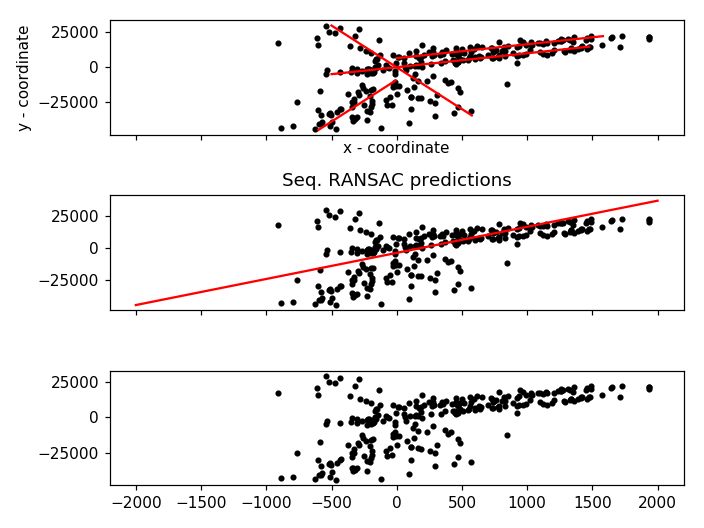

In [3]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.5, 3.0
var1 = 130;
var2 = 40
data = getLineData(10.0,20.0, -500, 1500, 25)
#Retain original and mess data to plot base truth lines
mData = copy.deepcopy(data)
addNoise(mData, var1, var2)
# # parameters for "true" lines y = a*x + b
# a2, b2 = 15, 40

# generate the "true" line points
data2 = getLineData(10.0,6500.0, 0, 1600,20)    # staking data points into (Nx2) array
mData2 = copy.deepcopy(data2)
addNoise(mData2, var1, var2)

data3 = getLineData(-60.0, -90.0, -500, 600,25)
mData3 = copy.deepcopy(data3)
addNoise(mData3, var1,var2)

data4 = getLineData(60.0, -9000.0, -600, 0,10)
mData4 = copy.deepcopy(data4)
addNoise(mData4, var1, var2)

#Get final data as combination of mess data points
faultyX = np.random.uniform(-1500, 1500,250)
faultyY = np.random.uniform(1900000, 200000,250)
faulty = np.array((faultyX, faultyY))
faulty = faulty.T
faulty += 180 * np.random.normal(size=faulty.shape)
#finalData = np.concatenate((mData,faulty))
finalData = np.concatenate((mData, mData2, mData3, mData4))# combining with previous data
fig, ax = plt.subplots(3,1, sharex = True)
ax[0].plot(finalData[:,0], finalData[:,1], '.k', label='data points (w. noise & outliers)')
ax[0].plot(data[:,0], data[:,1], '-r', label='ground')
ax[0].plot(data2[:,0], data2[:,1], '-r', label='ground')
ax[0].plot(data3[:,0], data3[:,1], '-r', label='ground')
ax[0].plot(data4[:,0], data4[:,1], '-r', label='ground')

ax[1].plot(finalData[:,0], finalData[:,1], '.k', label='data points (w. noise & outliers)')
ax[2].plot(finalData[:,0], finalData[:,1], '.k', label='data points (w. noise & outliers)')
ax[0].set_xlabel('x - coordinate')
ax[0].set_ylabel('y - coordinate')
#ax[0].legend(loc='lower left')
#ax[0].set_title('Ground truth')
#Keep track of how many lines have been predicted by seq. RANSAC
numRansacLines = 0

In [4]:
#Initialization of data for seq. RANSAC below
ransacFinalData = copy.deepcopy(finalData)

## Seq. RANSAC

In [5]:
#robustly fit line using RANSAC algorithm
numRansacLines += 1
model_robust, inliers = ransac(ransacFinalData, LeastSquareLine, min_samples=2, residual_threshold=12.5, max_trials=10)
a_rs, b_rs = model_robust.line_par()
ransacFinalData = ransacFinalData[list(map(lambda x: not x, inliers))]
line_x = np.arange(-2000, 2000)
line_y_robust = model_robust.predict_y(line_x)
a_ls, b_ls = model_robust.line_par()
print('Ransac params - a: ' + str(a) + ' b: ' + str(b_ls))
ax[1].plot(line_x, line_y_robust, '-r', label='Seq. RANSAC line(#: {}, a={:4.2f}, b={:4.1f})'.format(numRansacLines,a_ls,b_ls))
ax[1].set_title('Seq. RANSAC predictions')
fig.tight_layout()

Ransac params - a: 0.5 b: -4121.911023915877


## K-means-based UFL
The following code cell is for k-means-based UFL optimization. The base code is taken from refactored from assignment 3, with updates to allow the clusters to be generalized to full models (in this case linear models), rather than each one being a single point.

In [6]:
class MyKmeansApp:
    
    def __init__(self, num_models, data):
        self.k = num_models
        self.shape = data.shape
        self.iteration = 0   # iteration counter
        self.energy = np.infty  # energy - "sum of squared errors" (SSE)
        #Min. percent of the total dataset represented by a line
        #for it to be kept
        self.means = np.zeros((self.k,2),'d') # creates a zero-valued (double) matrix of size Kx5
        self.init_means()
        #Threshold for min. parameter difference between models
        self.mergeThresh = 15
        self.no_label = num_models  # special label value indicating pixels not in any cluster (e.g. not yet) 
        #Label elements are 3 vectors: (x,y) coordinates, followed by model (cluster) identifier
        self.labels = np.zeros((data.shape[0],3))
        for i in range(data.shape[0]):
            self.labels[i][0:2] = np.array(data[i][0:2])

    #Initialize the models with random parameters
    def init_means(self):
        self.iteration = 0           # resets iteration counter 
        self.energy = np.infty       # and the energy
        #Choose a large range for parameters to make the function more extendable
        #For the sake of demonstration, they are kept localized around real models
        #to make convergence faster
        self.means = np.random.uniform(-10000, 10000, (self.k, 2))
    
    #Takes a list of mean indices and merges them
    #Adjusts the labels for any points pointing to previously used means
    #Uses the provided label
    def mergeMeans(self,newLabel, meanList):
        #Aggregate labels to the
        newMean = self.means[meanList[0]]
        for i in range(self.labels.shape[0]):
            label = self.labels[i]
            if(label[2] in meanList):
                label[2] = newLabel
        
    #Called at the end of compute_means
    #Merges any models where the difference in the
    #sum of their parameters is less than our threshold, simThresh
    def checkMeans(self):
        mergedIndices = np.zeros(self.means.shape[0], dtype=bool)
        newMeans = np.zeros(self.means.shape[0], dtype=bool)
        indices = np.arange(0,self.means.shape[0])
        for i in range(self.means.shape[0]):    
            localMerge = np.zeros(self.means.shape[0], dtype=bool)
            if(mergedIndices[i]):
                continue;
            mean1 = self.means[i]
            remIndices = np.arange(i+1, self.means.shape[0])
            for j in remIndices:
                if(mergedIndices[j]):
                    continue;
                mean2 = self.means[j];
                if(np.linalg.norm(mean1[0:2]-mean2[0:2]) < self.mergeThresh):
                    localMerge[j] = True
                    mergedIndices[j] = True
            if(localMerge.sum() > 0):
                newMeans[i] = True
                self.mergeMeans(i, indices[localMerge])
        self.means = self.means[newMeans]

    #Recalculates lines using least-squares estimation on their inliers
    def compute_means(self):
        labels = self.labels
        #May use the non-empty cluster count to trim models while iterating
        non_empty_clusters = 0
        #Reset means
        self.means = np.zeros((self.k,2),'d')
        #Mark the means that we want to remove
        keepIndices = np.zeros(self.means.shape[0], dtype=bool)
        #For each model, do least-squares on all the points associated with it
        #Could be optimized to only 1 pass over the list of points - consider if it's too slow
        for label in range(self.k):
            #Extract points
            points = np.array(list(filter(lambda x: x[2] == label, labels)))
            #Use this to trim models if they don't have enough points associated with them
            if(points.shape[0] <= 8):
                continue
            keepIndices[label] = True
            non_empty_clusters += 1
            #print('Points', points)
            #Perform least-squares to get new params
            LSline = LeastSquareLine()
            LSline.estimate(points[:,0:2])
            a_ls, b_ls = LSline.line_par()
            #print('Estimation:' + str(a_ls) + ' b: ' + str(b_ls))
            #Update mean
            self.means[label] = np.array([a_ls, b_ls])
        #print('Means', self.means)
        #print('Keep', keepIndices)
        self.means = self.means[keepIndices]
        return non_empty_clusters
    
    #Return the min. distance between the point and the line
    #Line given as y=mx+b, (m,b), point is (x,y)
    #Assumes that the lines aren't perfectly vertical or perfectly horizontal (may update to allow both cases)
    def distToLine(self, line, point):
        return abs(line[0]*point[0] - point[1] + line[1])/math.sqrt(line[0]*line[0] + line[1]*line[1])
    
    # Matches each point with the closest line to it (Euclidean distance)
    def compute_labels(self):
        energy = 0
        labels = self.labels
        #print('Means', self.means)
        #For each point, calculate the minimum-dist mean from it.
        #Somewhat inefficient algo... Is there a better way?
        for i in range(labels.shape[0]):
            #Point is a tuple: first element is the tuple (x,y) coordinates,
            #second is the label it is assigned to
            point = labels[i]
            min_dist = np.inf
            for label in range(self.k):
                mean = self.means[label]
                #print('Mean', mean)
                #print('Point', point)
                #Dist from mean line
                dist = self.distToLine(mean, point)
               # print('Dist: ', dist)
                #print('Dist to line', dist)
                if(dist < min_dist):
                    min_dist = dist;
                    point[2] = label
            #Add the min dist to the energy
            energy += min_dist
            #print('Energy: ', energy)
        #print('Updated labels', self.labels)
        return energy

    #Graph the current models
    def graphModels(self, x_min, x_max):
        for model in self.means: 
            data = getLineData(model[0], model[1], x_min, x_max)
            ax[2].plot(data[:,0], data[:,1], '-r')
        fig.tight_layout();

    # The function below is called by "on_key_down" in KmeansPresenter".
    # It's goal is to run an iteration of K-means procedure
    # updating the means and the (segment) labels
    def compute_k_means_clusters(self):  
        self.iteration += 1
        # the main two steps of K-means algorithm
        self.energy = self.compute_labels()
        #Check for convergence based on energy change
        #Update threshold empirically-choose randomly for now
        self.k = self.compute_means()
        return self.energy

In [7]:
# #Use k-means based UFL for line prediction, and plot the results
# #Choose arbitrarily large k for now - keep relatively small for demonstration purposes
#print('Final Data: ', finalData)
kMeansApp = MyKmeansApp(10000,finalData)
converged = False
prevEnergy = 0
# #print('Dist: ' , kMeansApp.distToLine([ 0.5, -997], [0,-997]))
# print('Pre Labels ', kMeansApp.labels)
# print('Pre Means', kMeansApp.means)
# kMeansApp.checkMeans()
# print('Pre Labels ', kMeansApp.labels)
# print('Post Means: ', kMeansApp.means)

while(converged != True):
    newEnergy = kMeansApp.compute_k_means_clusters()
    #print('new energy: ', newEnergy)
    if(abs(newEnergy - prevEnergy) <= 0.5):
        converged = True
    prevEnergy = newEnergy
print('Iterations:', kMeansApp.iteration)
print('Converged models: ', kMeansApp.means)

Iterations: 6
Converged models:  [[ 1.05427087e+01 -1.89549045e+03]
 [ 1.01390845e+01  5.82950425e+02]
 [ 3.20073118e+01 -7.15305955e+03]
 [ 1.65665275e+00  1.15608583e+04]
 [ 2.84087046e+01 -2.16856333e+04]]


In [8]:
#kMeansApp.graphModels(-500, 1600)

# References
(potential):https://www.cs.cmu.edu/~anupamg/adv-approx/lecture4.pdf, http://www.csd.uwo.ca/~yuri/Papers/ijcv10_labelcost.pdf, https://estudogeral.sib.uc.pt/bitstream/10316/40543/1/Solving%20the%20uncapacitated%20facility%20location%20problem.pdf

G. Cornuejols, G.L. Nemhauser, and L.A. Wolsey. The uncapacitated facility location problem.
In P. Mirchandani and R. Francis, editors, Discrete Location Theory, pages 119{171. John Wiley
and Sons, Inc., New York, 1997.

https://www.cs.dartmouth.edu/~deepc/Courses/F10/Notes/lec1.pdf

https://estudogeral.sib.uc.pt/bitstream/10316/40543/1/Solving%20the%20uncapacitated%20facility%20location%20problem.pdf

https://www.cs.dartmouth.edu/~deepc/Courses/F10/Notes/lec1.pdf
http://proceedings.mlr.press/v9/lazic10a/lazic10a.pdf